# PROGRAMA 2

## Objetivo:
- Implementación de una red neuronal para la detección de ciberacoso a partir de una recopilación de tweets (actualmente X's).erior uso.

## Tratamiento y visualización de los datos

In [2]:
#Importación de los datos
import pandas as pd
data_train = pd.read_csv('E:\MATERIAS CURSADAS\ONCEAVO SEMESTRE\PLN\cyberbullying_train.csv')
data_test = pd.read_csv('E:\MATERIAS CURSADAS\ONCEAVO SEMESTRE\PLN\cyberbullying_test.csv')
data_valid = pd.read_csv('E:\MATERIAS CURSADAS\ONCEAVO SEMESTRE\PLN\cyberbullying_val.csv')

data_train.head()

,tweet_text,cyberbullying_type
0,@AntonSirius @erinspice @prpltnkr @ChiefElk oh...,other_cyberbullying
1,"Ladies ""Bedroom Bully"" The Mix Cd By @GappyRan...",not_cyberbullying
2,RT @_bobbidana: Never thought I'd say this but...,not_cyberbullying
3,She is intellectual terrorists and world suffe...,religion
4,You saudias are not friends of Muslim idiots c...,religion


In [3]:
data_test.head()

,tweet_text,cyberbullying_type
0,"@dankmtl Yeap, as a little Propaganda Nazi for...",religion
1,@LyndseyBoo wow!! Leave lyndsey phone alone!!!...,other_cyberbullying
2,"I'm not a man, only know how to bully people :(",other_cyberbullying
3,@urgedharry @nyazpolitics @greenlinerzjm If yo...,religion
4,Calling people dumb isnt nice :( RT @tayyoung_...,ethnicity


In [4]:
data_valid.head()

,tweet_text,cyberbullying_type
0,But you idiot tagged and more also I'm a Muslim,religion
1,@SEXYLALA That's a dumb nigger never fuck LALA...,ethnicity
2,I never hear hispanics calling each other brow...,ethnicity
3,@Lenny_Banx nigger read it again such a dumb a...,ethnicity
4,She was a mean girl in high school. She and Mi...,age


In [5]:
#Bibliotecas necesarias
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Disable tensorflow debugging logs
os.environ["KERAS_BACKEND"] = "torch"
import keras
import torch

torch.__version__, keras.__version__

('2.4.1+cpu', '3.5.0')

- Clasificación en clases de los tipos de twwets que tenemos

In [6]:
#Uso de tf.data para la clasificación de clases a partir de vectores ONE-HOT
import tensorflow as tf

#Vectores ONE-HOT del conjunto de entrenamiento, prueba y validación
vector_train = data_train['cyberbullying_type']
vector_test = data_test['cyberbullying_type']
vector_val = data_valid['cyberbullying_type']

def mapeo_one_hot(vectores):
    categorias = list(set(vectores))
    valor_categorias = {vectores: index for index, vectores in enumerate(categorias)}

    indices = [valor_categorias[vector] for vector in vectores]

    one_hot = tf.one_hot(indices, depth=len(categorias))

    return one_hot

one_hot_train = mapeo_one_hot(vector_train)
one_hot_test = mapeo_one_hot(vector_test)
one_hot_val = mapeo_one_hot(vector_val)

print(one_hot_train.numpy())

[[1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 ...
 [0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]]


In [7]:
import tensorflow as tf
from keras.layers import TextVectorization
from sklearn.model_selection import train_test_split
import time

X_train = data_train['tweet_text'].values
y_train = one_hot_train

x_test = data_test['tweet_text'].values
y_test = one_hot_test

x_val = data_valid['tweet_text'].values
y_val = one_hot_val

In [8]:
len(X_train), len(x_test), len(x_val)

(33384, 7154, 7154)

In [9]:
raw_train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
raw_test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
raw_val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))

In [10]:
# Tamaño de vocabulario
vocab_size = 10000

vectorize_layer = TextVectorization(
    standardize=None,
    max_tokens=vocab_size,
    output_mode='tf-idf')

# Obtener el texto sin etiquetas
text_ds = raw_train_ds.map(lambda x, y: x)
start = time.time()
vectorize_layer.adapt(text_ds)
print(f'Time for adapt is {time.time()-start:.4f}')

Time for adapt is 182.2222


In [11]:
batch_size = 16
raw_train_ds = raw_train_ds.shuffle(20000).batch(batch_size)
raw_test_ds = raw_test_ds.batch(batch_size)
raw_val_ds = raw_val_ds.batch(batch_size)

In [12]:
for inp, target in raw_train_ds.take(1):
    print(inp[:2], target[:2])

tf.Tensor(
[b'I hope Kat breaks both of her ankles. #MKR'
 b"Watched college football &amp; basketball all day. Now I'm ending my night with some MNF.....on Saturday"], shape=(2,), dtype=string) tf.Tensor(
[[0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1.]], shape=(2, 6), dtype=float32)


In [13]:
vectorize_layer(inp)

tensor([[ 7.5457,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [15.0915,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [30.1829,  1.2918,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [22.6372,  1.2918,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [22.6372,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 7.5457,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])

In [14]:
def preprocess(x, y):
    x = vectorize_layer(x)
    return x, y

train_ds = raw_train_ds.map(lambda x, y: preprocess(x, y))
val_ds = raw_val_ds.map(lambda x, y: preprocess(x, y))
test_ds = raw_test_ds.map(lambda x, y: preprocess(x, y))

In [15]:
next(iter(train_ds))

(<tf.Tensor: shape=(16, 10000), dtype=float32, numpy=
 array([[15.091464 ,  0.       ,  0.       , ...,  0.       ,  0.       ,
          0.       ],
        [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
          0.       ],
        [ 7.545732 ,  1.2917804,  0.       , ...,  0.       ,  0.       ,
          0.       ],
        ...,
        [22.637196 ,  0.       ,  0.       , ...,  0.       ,  0.       ,
          0.       ],
        [15.091464 ,  0.       ,  0.       , ...,  0.       ,  0.       ,
          0.       ],
        [ 0.       ,  1.2917804,  0.       , ...,  0.       ,  0.       ,
          0.       ]], dtype=float32)>,
 <tf.Tensor: shape=(16, 6), dtype=float32, numpy=
 array([[0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0.],
        [1., 0., 

- Construcción del modelo de red neuronal.

In [163]:
class Linear(keras.layers.Layer):
    def __init__(self, num_outputs, activation=None):
        super().__init__()
        self.num_outputs = num_outputs
        self.activation = keras.activations.get(activation)

    def build(self, input_shape):
      input_dim = input_shape[-1]
      self.w = self.add_weight(shape=[input_dim,
                                      self.num_outputs],
                               name = 'kernel')
      self.b = self.add_weight(shape=[self.num_outputs],
                               name = 'bias')

    def call(self, inputs):
      x = keras.ops.matmul(inputs, self.w) + self.b
      return self.activation(x)

In [164]:
test_batch = next(iter(test_ds))
test_batch[0]

<tf.Tensor: shape=(16, 10000), dtype=float32, numpy=
array([[22.637196 ,  1.2917804,  1.3641971, ...,  0.       ,  0.       ,
         0.       ],
       [45.27439  ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [ 0.       ,  0.       ,  1.3641971, ...,  0.       ,  0.       ,
         0.       ],
       ...,
       [37.72866  ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [30.182928 ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [ 7.545732 ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ]], dtype=float32)>

In [165]:
val_batch = next(iter(val_ds))
val_batch[0]

<tf.Tensor: shape=(16, 10000), dtype=float32, numpy=
array([[ 7.545732 ,  0.       ,  1.3641971, ...,  0.       ,  0.       ,
         0.       ],
       [15.091464 ,  0.       ,  1.3641971, ...,  0.       ,  0.       ,
         0.       ],
       [30.182928 ,  2.5835607,  1.3641971, ...,  0.       ,  0.       ,
         0.       ],
       ...,
       [30.182928 ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [75.45732  ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [ 7.545732 ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ]], dtype=float32)>

In [183]:
from tensorflow.keras.layers import Dropout 

class Model(keras.Model):
    def __init__(self, activation):
        super().__init__()
        self.l1 = Linear(24, activation=activation)
        Dropout(0.5)
        self.l2 = Linear(18)
        Dropout(0.5)
        self.l3 = Linear(18, activation=activation)
        Dropout(0.5)
        self.l4 = Linear(18)
        Dropout(0.5)
        self.l5 = Linear(6, activation=activation)

    def call(self, x):
        x = self.l1(x)
        x = self.l2(x)
        x = self.l3(x)
        x = self.l4(x)
        x = self.l5(x)
        return x

model = Model('softmax')

In [185]:
model(test_batch[0]).shape, test_batch[1].shape

(torch.Size([16, 6]), TensorShape([16, 6]))

In [186]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Definir los callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=4),  # Detener cuando la pérdida de validación no mejore por 3 épocas consecutivas.
    ModelCheckpoint(filepath='best_model.keras', monitor='val_loss', save_best_only=True)  # Guardar el mejor modelo.
]

model.compile(
    optimizer=keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=["accuracy"]
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=callbacks,
    batch_size=val_batch
)

y_pred_score = model.predict(
    test_ds,
    callbacks=callbacks
)


history2 = model.evaluate(
    test_ds,
    batch_size=test_batch
)

Epoch 1/15
2087/2087 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.4463 - loss: 1.3000 - val_accuracy: 0.7503 - val_loss: 0.6815
Epoch 2/15
2087/2087 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.7914 - loss: 0.5266 - val_accuracy: 0.7945 - val_loss: 0.5430
Epoch 3/15
2087/2087 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.8735 - loss: 0.3240 - val_accuracy: 0.8082 - val_loss: 0.5763
Epoch 4/15
2087/2087 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.9132 - loss: 0.2287 - val_accuracy: 0.7944 - val_loss: 0.6607
Epoch 5/15
2087/2087 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.9320 - loss: 0.1744 - val_accuracy: 0.7924 - val_loss: 0.7741
Epoch 6/15
2087/2087 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.9423 - loss: 0.1469 - val_accuracy: 0.7780 - val_loss: 0.9002
448/448 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
448/448 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7868 - loss: 0.8453


In [187]:
history.history

{'accuracy': [0.5868380069732666,
  0.8075125813484192,
  0.8743709325790405,
  0.9089983105659485,
  0.9279595017433167,
  0.9384136199951172],
 'loss': [0.9933810234069824,
  0.4905371367931366,
  0.31812790036201477,
  0.23721732199192047,
  0.18421974778175354,
  0.14910687506198883],
 'val_accuracy': [0.7503494620323181,
  0.7945205569267273,
  0.8082191944122314,
  0.794380784034729,
  0.7924238443374634,
  0.778026282787323],
 'val_loss': [0.6814584732055664,
  0.5429730415344238,
  0.5762804746627808,
  0.6607041358947754,
  0.7740753293037415,
  0.9002028107643127]}

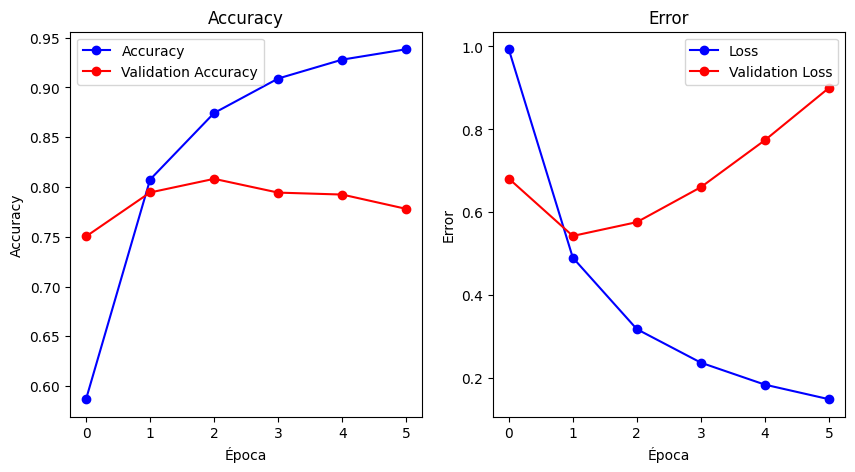

In [188]:
import numpy as np
import matplotlib.pyplot as plt

# Crear figura con dos subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot de accuracy en el primer subplot
ax1.plot(history.history['accuracy'], 'bo-', label='Accuracy')
ax1.plot(history.history['val_accuracy'], 'ro-', label='Validation Accuracy')
ax1.set_title('Accuracy')
ax1.set_xlabel('Época')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot de error en el segundo subplot
ax2.plot(history.history['loss'], 'bo-', label='Loss')
ax2.plot(history.history['val_loss'], 'ro-', label='Validation Loss')
ax2.set_title('Error')
ax2.set_xlabel('Época')
ax2.set_ylabel('Error')
ax2.legend()

# Mostrar figura
plt.show()

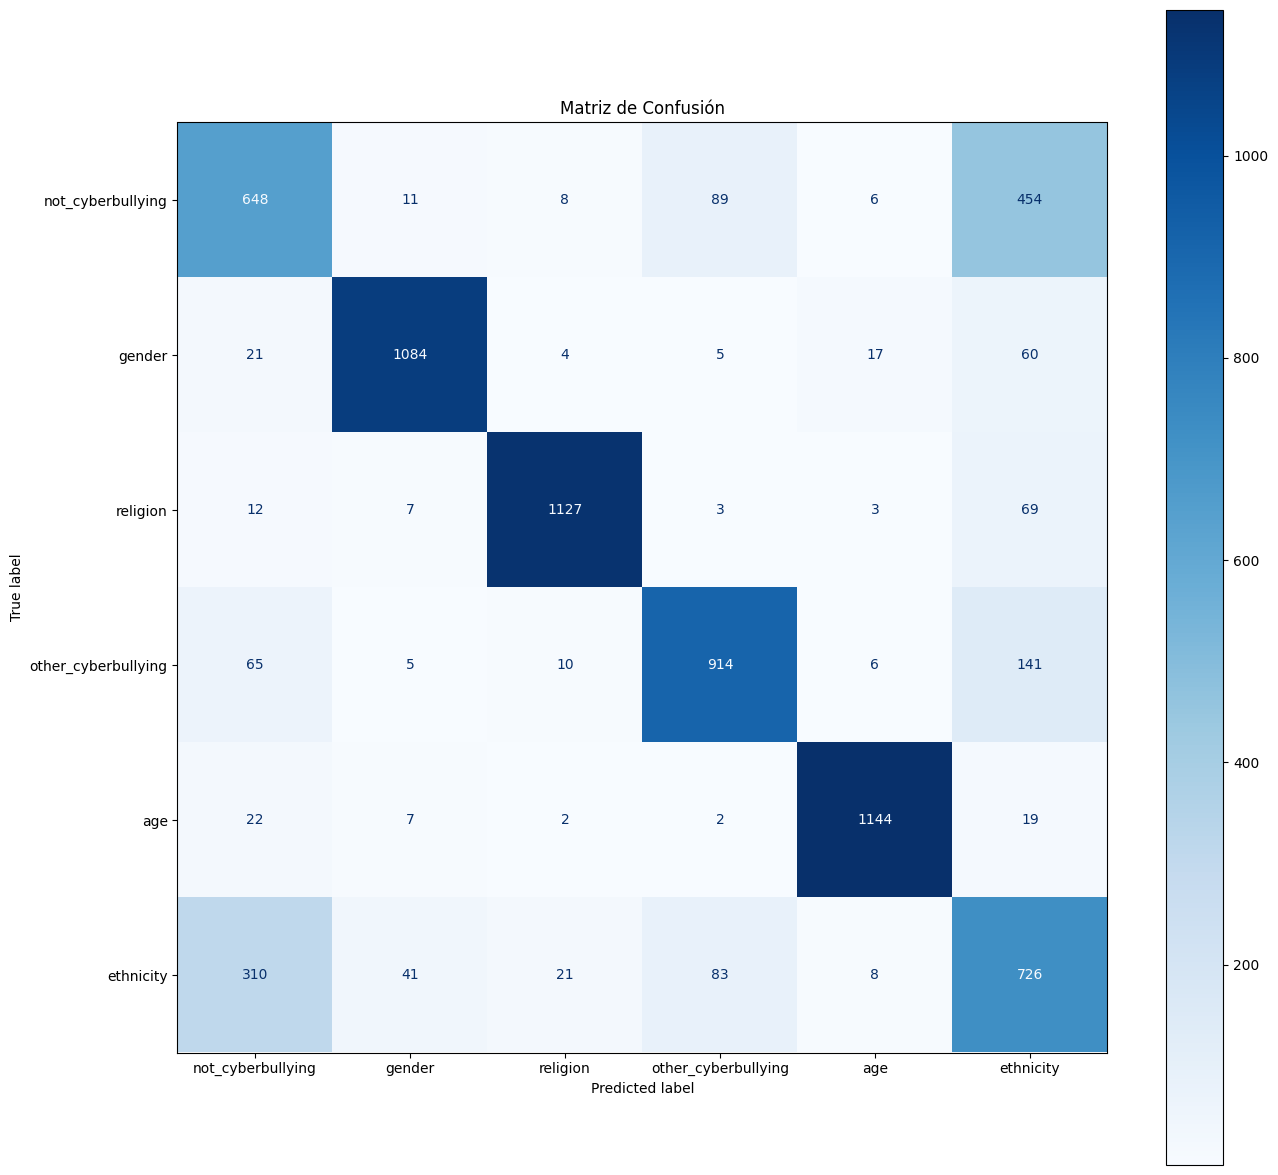

In [189]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = np.argmax(y_pred_score, axis=1)
y_true = np.argmax(y_test, axis=1)
conf_matrix = confusion_matrix(y_true, y_pred)

nombres_clase = ['not_cyberbullying', 'gender', 'religion', 'other_cyberbullying', 'age', 'ethnicity']

plt.figure(figsize=(15,15))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=nombres_clase)
disp.plot(cmap=plt.cm.Blues, ax=plt.gca())
plt.title("Matriz de Confusión")
plt.show()